In [367]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn as nn
from sklearn.model_selection import train_test_split


def sigmoid(x, L, d, nb_points=200, hidden_param = [0.8, 0, 0]):
    """This function generates the NCEL signal"""
    #generate a sigmoid function
    k = hidden_param[0]
    x = np.linspace(0, 200, nb_points)
    y = 1/(1+np.exp(-k*(x-d-50)))
    y = (y/np.max(y))*(L+hidden_param[1]) 
    #change slope of the sigmoid function
    y = y + (x-d)*hidden_param[2]/100
    return y

def target_generator(delay, amplitude):
    return delay * amplitude

def generate_noisy_sigmoid(x):
    n_points = len(x)
    #normal distribution of the noise
    d = np.random.normal(50, 5)
    L = np.random.normal(10, 0.2)
    y = L / (1 + np.exp(-(x - d)))
    noise = np.random.normal(0, 0.0001, n_points)  # Ensure noise has the same shape as x
    return y + noise, d, L, noise

def generate_data(N, times):
    data = []
    delays = []
    amplitudes = []
    target_values = []
    for i in range(N):
        y, d, L, _ = generate_noisy_sigmoid(times)
        data.append(y)
        delays.append(d)
        amplitudes.append(L)
        target_values.append(target_generator(d, L))
    return np.array(data), np.array(delays), np.array(amplitudes), np.array(target_values)



class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        # Ajouter l'argument num_layers pour spécifier le nombre de couches LSTM
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialiser l'état caché et l'état de la cellule
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        # x de forme: [batch_size, seq_len, input_dim]
        lstm_out, _ = self.lstm(x, (h0, c0))
        # Sélectionner la dernière sortie temporelle pour chaque séquence
        last_time_step = lstm_out[:, -1, :]
        y_pred = self.linear(last_time_step)
        return y_pred

class CustomTransformerEncoderLayer(nn.TransformerEncoderLayer):
    def __init__(self, *args, **kwargs):
        super(CustomTransformerEncoderLayer, self).__init__(*args, **kwargs)
        self.self_attn_weights = None

    def forward(self, src, src_mask=None, src_key_padding_mask=None, is_causal=False):
        src2 = self.self_attn(src, src, src, attn_mask=src_mask, key_padding_mask=src_key_padding_mask)[0]
        self.self_attn_weights = self.self_attn(src, src, src, attn_mask=src_mask, key_padding_mask=src_key_padding_mask)[1]
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

class TransformerModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, nhead):
        super(TransformerModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.input_dim = input_dim

        # Define a linear layer to transform input to embedding dimension
        self.input_linear = nn.Linear(input_dim, hidden_dim)
        
        # Positional encoding to add position information to the input embeddings
        self.positional_encoding = nn.Parameter(torch.zeros(1, 5000, hidden_dim))

        # Define the Transformer encoder layer
        encoder_layer = CustomTransformerEncoderLayer(d_model=hidden_dim, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Define the output linear layer
        self.linear = nn.Linear(hidden_dim, output_dim)
        
        self.attention_weights = None

    def forward(self, x):
        # x shape: [batch_size, seq_len, input_dim]
        
        # Apply linear transformation to input to get embeddings
        x = self.input_linear(x)
        
        # Add positional encoding
        seq_len = x.size(1)
        x += self.positional_encoding[:, :seq_len, :]

        # Transformer expects input of shape [seq_len, batch_size, hidden_dim]
        x = x.transpose(0, 1)
        
        # Pass through the transformer encoder
        transformer_out = self.transformer_encoder(x)
        
        # Select the last time step's output
        last_time_step = transformer_out[-1, :, :]

        # Pass through the final linear layer to get predictions
        y_pred = self.linear(last_time_step)
        
        # Store attention weights
        self.attention_weights = [layer.self_attn_weights for layer in self.transformer_encoder.layers]
        
        return y_pred

    def get_attention_weights(self):
        return self.attention_weights

def make_model(input_dim, hidden_dim, output_dim, num_layers, lr=0.01):
    model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    return model, criterion, optimizer, device

def split_data(features_normalized, target_normalized, device, test_size=0.2):
    features_train, features_test, target_train, target_test = train_test_split(
    features_normalized, target_normalized, test_size=test_size, random_state=42)

    # Convertir en tenseurs PyTorch et envoyer au dispositif approprié
    features_train_tensor = torch.tensor(features_train, dtype=torch.float).to(device)
    target_train_tensor = torch.tensor(target_train, dtype=torch.float).to(device)
    features_test_tensor = torch.tensor(features_test, dtype=torch.float).to(device)
    target_test_tensor = torch.tensor(target_test, dtype=torch.float).to(device)
    return features_train_tensor, target_train_tensor, features_test_tensor, target_test_tensor

def train_model(model, optimizer, criterion, features_train_tensor, target_train_tensor, features_test_tensor, target_test_tensor, n_epochs=300, patience=100):
    best_loss = np.inf
    epochs_no_improve = 0
    loss_save = []
    r2_save = {}
    best_r2 = float('-inf')
    epochs_no_improve_r2 = 0

    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(features_train_tensor)
        loss = criterion(y_pred, target_train_tensor)
        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            y_val_pred = model(features_test_tensor)
            val_loss = criterion(y_val_pred, target_test_tensor)
            # Calcul du R² sur l'ensemble de validation
            r2_val = 1 - val_loss / torch.var(target_test_tensor)
            r2_train = 1 - loss / torch.var(target_train_tensor)

        # Vérifier si le R² de validation s'est amélioré de 0.01
        if torch.abs(r2_val - best_r2) > 0.01:
            best_r2 = r2_val
            epochs_no_improve_r2 = 0
            print(f'Epoch {epoch + 1}, Improved R²: {best_r2.item()}')
        else:
            epochs_no_improve_r2 += 1
            if epochs_no_improve_r2 == patience:
                print(f'Early stopping! Epoch {epoch + 1}, Best R²: {best_r2.item()}')
                break  # Arrêt anticipé

        # Optionnel: Enregistrer la perte d'entraînement pour visualisation
        loss_save.append(loss.item())
        r2_save[epoch] = {'train_loss': loss.item(), 'val_loss': val_loss.item(), 'r2': r2_val.item(),
                            'train_r2': r2_train.item()}

    # Visualisation de la perte d'entraînement
    fig, (ax, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    ax.plot(loss_save, label='Training Loss', color='blue')
    ax.plot([x['val_loss'] for x in r2_save.values()], label='Validation Loss', color='red')
    #log scale y axis
    ax.set_yscale('log')
    ax.set_title('Training Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax2.plot([x['r2'] for x in r2_save.values()], label='R² test', color='green')
    ax2.plot([x['train_r2'] for x in r2_save.values()], label='R² train', color='blue')
    ax2.legend()
    ax2.set_title('R² Score')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('R²')
    #ax2 between 0 and 1
    ax2.set_ylim(0, 1)
    plt.show()

    return model
    

(1000, 60) (1000,) (1000,) (1000,)


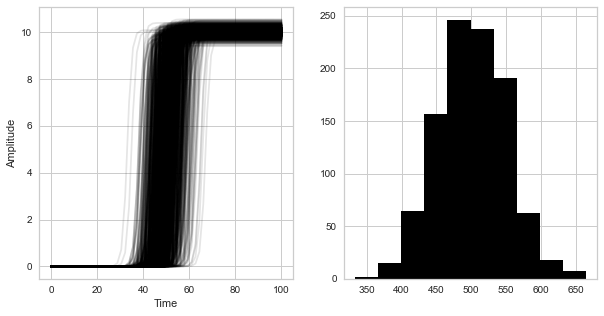

In [368]:
N = 1000
times = np.linspace(0, 100, 60)
np.random.seed(0)
data, delays, amplitudes, target_value = generate_data(N, times)
print(data.shape, delays.shape, amplitudes.shape, target_value.shape)

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 5))
for i in range(N):
    ax.plot(times, data[i], color='black', alpha=0.1)
ax.set_xlabel('Time')
ax.set_ylabel('Amplitude')
_ = ax1.hist(target_value, color='black')

Text(0, 0.5, 'Count')

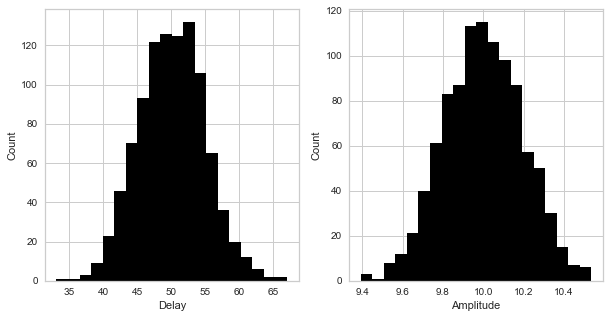

In [369]:
#plot the distibution of the delays and lum 
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 5))
ax.hist(delays, bins=20, color='black')
ax.set_xlabel('Delay')
ax.set_ylabel('Count')
ax1.hist(amplitudes, bins=20, color='black')
ax1.set_xlabel('Amplitude')
ax1.set_ylabel('Count')

In [370]:
#classical ML 
#import pycaret regression
"""
from pycaret.regression import *
import pandas as pd 
#initialize setup
df_train = pd.DataFrame({'delay': delays, 'amplitude': amplitudes, 'target': target_value})
df_train.head(2)


reg = setup(data = df_train, target = 'target', session_id=123, verbose=False)
best = compare_models()
"""

"\nfrom pycaret.regression import *\nimport pandas as pd \n#initialize setup\ndf_train = pd.DataFrame({'delay': delays, 'amplitude': amplitudes, 'target': target_value})\ndf_train.head(2)\n\n\nreg = setup(data = df_train, target = 'target', session_id=123, verbose=False)\nbest = compare_models()\n"

In [371]:
features_normalized = data / np.max(data)
target_normalized = target_value / np.max(target_value)
#reshape feature in form [batch_size, seq_len, input_dim]
features_normalized = features_normalized[:, :, np.newaxis]

#convert to torch tensor
features_normalized = torch.tensor(features_normalized, dtype=torch.float)
target_normalized = torch.tensor(target_normalized, dtype=torch.float)

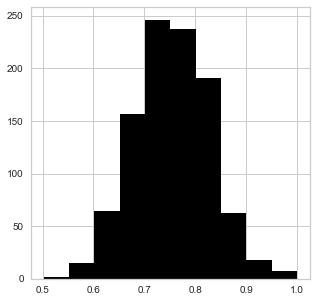

In [380]:
#plot target normalized
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
_ = ax.hist(target_normalized, color='black')

In [372]:
print('feature shape :', features_normalized.shape)
print('target shape :', target_normalized.shape)

feature shape : torch.Size([1000, 60, 1])
target shape : torch.Size([1000])


In [373]:
import warnings
warnings.filterwarnings("ignore")
model, criterion, optimizer, device = make_model(input_dim=1, hidden_dim=82, output_dim=1, num_layers=1, lr=0.021830968390524622)
features_train_tensor, target_train_tensor, features_test_tensor, target_test_tensor = split_data(features_normalized, target_normalized, device)
print('devices used :', device)

devices used : cuda


Epoch 1, Improved R²: -33.73270034790039
Epoch 2, Improved R²: -515.6268310546875
Epoch 3, Improved R²: -33.27143859863281
Epoch 4, Improved R²: -22.445709228515625
Epoch 5, Improved R²: -46.01923370361328
Epoch 6, Improved R²: -50.998382568359375
Epoch 7, Improved R²: -48.360130310058594
Epoch 8, Improved R²: -42.13520431518555
Epoch 9, Improved R²: -33.315696716308594
Epoch 10, Improved R²: -21.84016990661621
Epoch 11, Improved R²: -8.248862266540527
Epoch 12, Improved R²: -0.17649853229522705
Epoch 13, Improved R²: -16.503047943115234
Epoch 14, Improved R²: -4.771349906921387
Epoch 15, Improved R²: -0.18071842193603516
Epoch 16, Improved R²: -0.5050424337387085
Epoch 17, Improved R²: -1.9145874977111816
Epoch 18, Improved R²: -2.9458250999450684
Epoch 19, Improved R²: -3.225098133087158
Epoch 20, Improved R²: -2.812627077102661
Epoch 21, Improved R²: -1.9586751461029053
Epoch 22, Improved R²: -0.9966230392456055
Epoch 23, Improved R²: -0.26162147521972656
Epoch 24, Improved R²: 0.00

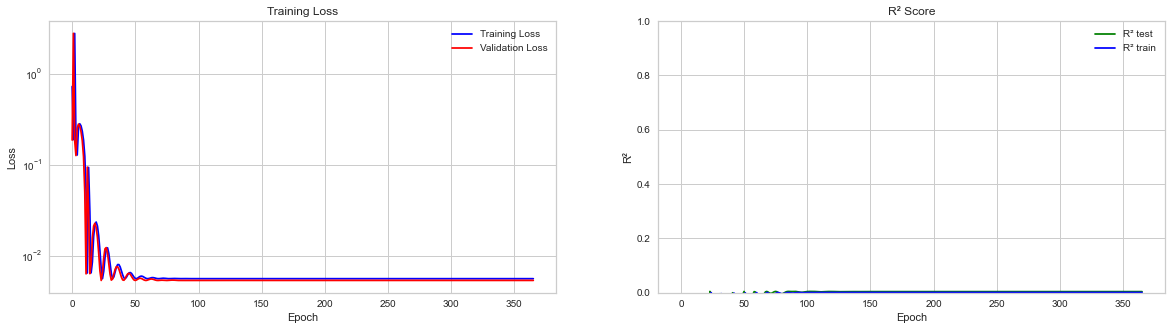

In [374]:
model = train_model(model, optimizer, criterion, features_train_tensor, target_train_tensor, features_test_tensor, target_test_tensor, n_epochs=1000, patience=300)

In [375]:
import torch
import torch.nn as nn
import torch.optim as optim
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

# Définir la fonction d'objectif pour l'optimisation bayésienne
def objective(params):
    hidden_dim, num_layers, lr = params
    hidden_dim = int(hidden_dim)  # Convertir hidden_dim en int
    num_layers = int(num_layers)  # Convertir num_layers en int
    
    model, criterion, optimizer, device = make_model(input_dim=1, hidden_dim=hidden_dim, output_dim=1, num_layers=num_layers, lr=lr)
    features_train_tensor, target_train_tensor, features_test_tensor, target_test_tensor = split_data(features_normalized, target_normalized, device)
    
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(features_train_tensor)
        loss = criterion(outputs, target_train_tensor)
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        predictions = model(features_test_tensor)
        val_loss = criterion(predictions, target_test_tensor)
    
    return val_loss.item()

# Définir l'espace de recherche pour les hyperparamètres
param_space = [
    Integer(10, 100, name='hidden_dim'),
    Integer(1, 3, name='num_layers'),
    Real(1e-4, 1e-1, prior='log-uniform', name='lr')
]

# Utiliser skopt pour optimiser les hyperparamètres
res = gp_minimize(objective, param_space, n_calls=20, random_state=42)

print(f"Best parameters: {res.x}")
print(f"Best validation loss: {res.fun}")

#create a model with the best hyperparameters



Best parameters: [12, 3, 0.02087883359679589]
Best validation loss: 0.005356170702725649


Epoch 1, Improved R²: -42.00647735595703
Epoch 2, Improved R²: -14.942334175109863
Epoch 3, Improved R²: -0.061112284660339355
Epoch 4, Improved R²: -12.10937786102295
Epoch 5, Improved R²: -7.9457855224609375
Epoch 6, Improved R²: -1.7663195133209229
Epoch 7, Improved R²: 0.0035462379455566406
Epoch 8, Improved R²: -0.9561225175857544
Epoch 9, Improved R²: -2.1647136211395264
Epoch 10, Improved R²: -2.635805606842041
Epoch 11, Improved R²: -2.3857340812683105
Epoch 12, Improved R²: -1.7242121696472168
Epoch 13, Improved R²: -0.9689759016036987
Epoch 14, Improved R²: -0.36010897159576416
Epoch 15, Improved R²: -0.036566734313964844
Epoch 17, Improved R²: -0.25176119804382324
Epoch 18, Improved R²: -0.5581129789352417
Epoch 19, Improved R²: -0.7846786975860596
Epoch 20, Improved R²: -0.8337079286575317
Epoch 21, Improved R²: -0.7036714553833008
Epoch 22, Improved R²: -0.4688938856124878
Epoch 23, Improved R²: -0.2287822961807251
Epoch 24, Improved R²: -0.06061983108520508
Epoch 25, Impr

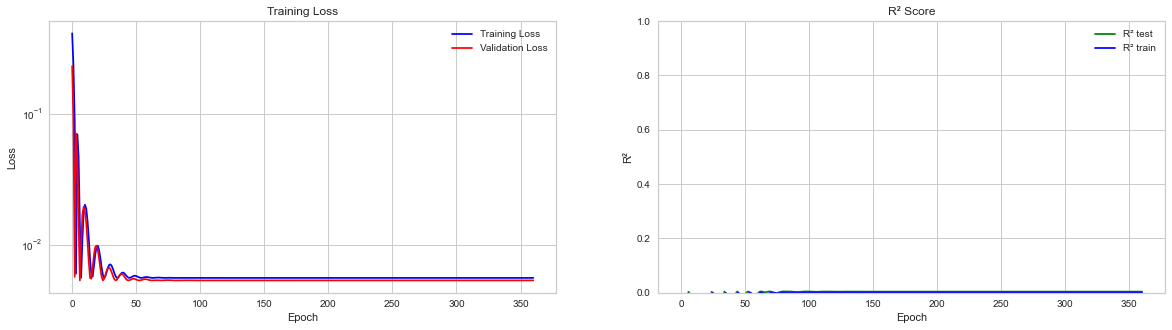

In [376]:

# Create a model with the best hyperparameters
hidden_dim, num_layers, lr = res.x
hidden_dim = int(hidden_dim)  # Convertir hidden_dim en int
num_layers = int(num_layers)  # Convertir num_layers en int
model, criterion, optimizer, device = make_model(input_dim=1, hidden_dim=hidden_dim, output_dim=1, num_layers=num_layers, lr=lr)
features_train_tensor, target_train_tensor, features_test_tensor, target_test_tensor = split_data(features_normalized, target_normalized, device)
model = train_model(model, optimizer, criterion, features_train_tensor, target_train_tensor, features_test_tensor, target_test_tensor, n_epochs=1000, patience=300)

Text(0, 0.5, 'Amplitude')

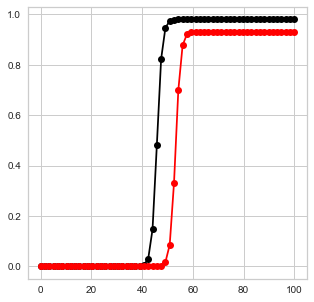

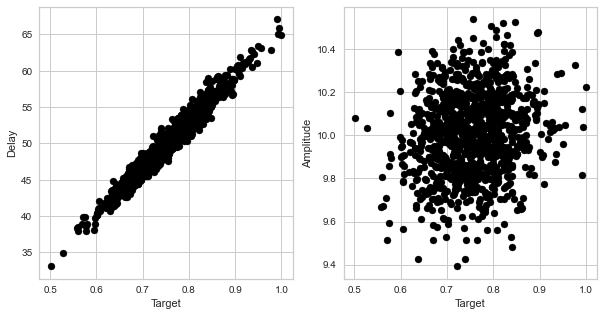

In [378]:
#plot randomly 1 signal
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
idx = np.random.randint(0, N)
ax.plot(times, features_normalized[idx].numpy(), color='black', marker='o', label='Feature')
idx2 = np.random.randint(0, N)
ax.plot(times, features_normalized[idx2].numpy(), color='red', marker='o', label='Feature')
#add on title with L, k, x0, b, d
#plot target vs delay 
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 5))
ax.scatter(target_normalized, delays, color='black')
ax.set_xlabel('Target')
ax.set_ylabel('Delay')
ax1.scatter(target_normalized, amplitudes, color='black')
ax1.set_xlabel('Target')
ax1.set_ylabel('Amplitude')